# 1D CNN Classifier


## Sprint Objective
- Understand the basics of **convolution** by building a **1D convolutional layer** from scratch.
- Implement forward & backward passes, padding, stride, and minibatching.
- Validate on **MNIST** by treating each 28×28 image as a 1D sequence of length 784.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import os

# Reproducibility
np.random.seed(42)
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['axes.grid'] = True

## 1) Load & Inspect MNIST

We try `keras.datasets.mnist` first; if not available, we fall back to a local NPZ (place `mnist.npz` at `/mnt/data/mnist.npz` or `~/.keras/datasets/mnist.npz`), then to `sklearn`'s OpenML.


Train shape: (60000, 28, 28)  Test shape: (10000, 28, 28)
Dtype: uint8


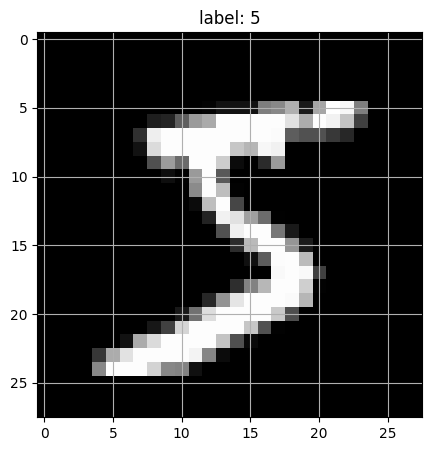

In [3]:
# Load MNIST directly from Keras
from keras.datasets import mnist


(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Dtype:", X_train.dtype)

# sneak peek
plt.imshow(X_train[0], cmap='gray'); plt.title(f'label: {y_train[0]}'); plt.show()

## 2) Preprocessing

- Flatten images to 1D of length 784 (we'll treat this as our sequence).
- Normalize to `[0,1]` float32.
- One-hot encode labels (10 classes).
- Split the 60k training set into 48k train / 12k validation.

In [4]:
# Flatten & normalize
X_train = X_train.reshape(-1, 784).astype(np.float32) / 255.0
X_test  = X_test.reshape(-1, 784).astype(np.float32) / 255.0

# One-hot encode
try:
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
except TypeError:
    enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_oh = enc.fit_transform(y_train.reshape(-1,1))
y_test_oh  = enc.transform(y_test.reshape(-1,1))

# Train/val split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train_oh, y_val_oh, y_train, y_val = train_test_split(
    X_train, y_train_oh, y_train, test_size=0.2, random_state=42, stratify=y_train
)
print('X_train:', X_train.shape, ' X_val:', X_val.shape, ' X_test:', X_test.shape)

X_train: (48000, 784)  X_val: (12000, 784)  X_test: (10000, 784)


## 3) Mini-batch iterator

In [5]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size=128, seed=42):
        self.batch_size = int(batch_size)
        rng = np.random.default_rng(seed)
        order = rng.permutation(np.arange(X.shape[0]))
        self._X = X[order]
        self._y = y[order]
        self._stop = int(np.ceil(X.shape[0]/self.batch_size))
        self._i = 0
    def __len__(self): return self._stop
    def __iter__(self):
        self._i = 0; return self
    def __next__(self):
        if self._i >= self._stop: raise StopIteration()
        p0 = self._i*self.batch_size; p1 = p0 + self.batch_size; self._i += 1
        return self._X[p0:p1], self._y[p0:p1]

## 4) Helpers: softmax, CE loss, accuracy

In [6]:
def softmax_stable(logits):
    shift = logits - logits.max(axis=1, keepdims=True)
    ex = np.exp(shift)
    return ex / ex.sum(axis=1, keepdims=True)

def cross_entropy(y_true_onehot, y_pred_proba, eps=1e-7):
    yp = np.clip(y_pred_proba, eps, 1.0-eps)
    return -np.mean(np.sum(y_true_onehot * np.log(yp), axis=1))

def accuracy_from_proba(y_true_int, y_pred_proba):
    pred = np.argmax(y_pred_proba, axis=1)
    return float((pred == y_true_int).mean())

## 5) Initializers & Optimizers

In [7]:
class SimpleInitializer:
    def __init__(self, sigma=0.01): self.sigma = float(sigma)
    def W(self, fan_in, fan_out): return self.sigma*np.random.standard_normal((fan_in, fan_out)).astype(np.float32)
    def B(self, fan_out): return np.zeros(fan_out, dtype=np.float32)

class XavierInitializer:
    def W(self, fan_in, fan_out):
        sigma = 1.0/np.sqrt(fan_in)
        return sigma*np.random.standard_normal((fan_in, fan_out)).astype(np.float32)
    def B(self, fan_out): return np.zeros(fan_out, dtype=np.float32)

class HeInitializer:
    def W(self, fan_in, fan_out):
        sigma = np.sqrt(2.0/fan_in)
        return sigma*np.random.standard_normal((fan_in, fan_out)).astype(np.float32)
    def B(self, fan_out): return np.zeros(fan_out, dtype=np.float32)

class SGD:
    def __init__(self, lr=0.1): self.lr = float(lr)
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.db
        return layer

class AdaGrad:
    def __init__(self, lr=0.1, eps=1e-8): self.lr = float(lr); self.eps=float(eps)
    def update(self, layer):
        if not hasattr(layer, 'hW'):
            layer.hW = np.zeros_like(layer.W, dtype=np.float32)
            layer.hB = np.zeros_like(layer.B, dtype=np.float32)
        layer.hW += layer.dW*layer.dW
        layer.hB += layer.db*layer.db
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.hW)+self.eps)
        layer.B -= self.lr * layer.db / (np.sqrt(layer.hB)+self.eps)
        return layer

## 6) Fully Connected layer (for output)

In [8]:
class FC:
    def __init__(self, n_in, n_out, initializer, optimizer):
        self.W = initializer.W(n_in, n_out)
        self.B = initializer.B(n_out)
        self.optimizer = optimizer
        self.X = None
        self.dW = None
        self.db = None
    def forward(self, X):
        self.X = X
        return X @ self.W + self.B
    def backward(self, dA):
        self.dW = self.X.T @ dA
        self.db = dA.sum(axis=0)
        dZ = dA @ self.W.T
        self.optimizer.update(self)
        return dZ

## 7) Activations & Softmax

In [9]:
class ReLU:
    def __init__(self): self.mask=None
    def forward(self, X):
        self.mask = (X>0).astype(np.float32)
        return np.maximum(0.0, X)
    def backward(self, dZ): return dZ * self.mask

class Tanh:
    def __init__(self): self.out=None
    def forward(self, X):
        self.out = np.tanh(X)
        return self.out
    def backward(self, dZ): return dZ * (1.0 - self.out**2)

class SoftmaxOutput:
    def forward(self, logits):
        return softmax_stable(logits)
    def backward(self, proba, y_true_onehot):
        N = y_true_onehot.shape[0]
        return (proba - y_true_onehot) / float(N)

## 8) Problem 2- Output size after 1D convolution

In [10]:
def conv1d_out_length(N_in, F, P=0, S=1):
    """Compute output length for 1D conv (valid padding P, stride S)."""
    return int((N_in + 2*P - F)/S) + 1

# Quick sanity checks
print('Out len examples:')
print('N=4,F=3,P=0,S=1 ->', conv1d_out_length(4,3,0,1), ' (expect 2)')
print('N=10,F=5,P=2,S=1 ->', conv1d_out_length(10,5,2,1), ' (same length 10)')
print('N=10,F=3,P=0,S=2 ->', conv1d_out_length(10,3,0,2))

Out len examples:
N=4,F=3,P=0,S=1 -> 2  (expect 2)
N=10,F=5,P=2,S=1 -> 10  (same length 10)
N=10,F=3,P=0,S=2 -> 4


## 9) Problem 1 - SimpleConv1d (1 channel, stride=1, no padding, batch=1)

In [11]:
class SimpleConv1d:
    """1D convolution with single input/output channel, batch size = 1, stride=1, no padding."""
    def __init__(self, F, initializer, optimizer):
        self.F = int(F)  # filter size
        self.W = initializer.W(self.F, 1).reshape(-1)  # store as (F,)
        self.B = initializer.B(1).reshape(-1)
        self.optimizer = optimizer
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        """x: shape (N_in,), returns a: shape (N_out,) where N_out = N_in - F + 1"""
        self.x = x.astype(np.float32)
        N_in = self.x.shape[0]
        N_out = N_in - self.F + 1
        idx = np.arange(self.F)[None, :] + np.arange(N_out)[:, None]  # (N_out, F)
        windows = self.x[idx]                                         # (N_out, F)
        a = windows @ self.W + self.B[0]                              # (N_out,)
        return a

    def backward(self, dA):
        """dA: shape (N_out,) -> returns dX: shape (N_in,)"""
        x = self.x; F = self.F; N_in = x.shape[0]; N_out = N_in - F + 1
        idx = np.arange(F)[None, :] + np.arange(N_out)[:, None]
        windows = x[idx]  # (N_out, F)

        self.dW = windows.T @ dA
        self.db = np.array([dA.sum()], dtype=np.float32)

        dX = np.zeros_like(x, dtype=np.float32)
        for i in range(N_out):
            dX[i:i+F] += dA[i] * self.W

        self.optimizer.update(self)
        return dX

## 10) Problem 3 -  Small-array check (forward & backward)

In [12]:
# Given example
x = np.array([1,2,3,4], dtype=np.float32)
w = np.array([3,5,7], dtype=np.float32)
b = np.array([1], dtype=np.float32)

conv = SimpleConv1d(F=3, initializer=SimpleInitializer(0.0), optimizer=SGD(lr=0.0))
conv.W = w.copy(); conv.B = b.copy()

a = conv.forward(x)
print('Forward a:', a)  # expect [35, 50]

delta_a = np.array([10, 20], dtype=np.float32)
dX = conv.backward(delta_a)
print('delta_b:', conv.db)   # expect [30]
print('delta_w:', conv.dW)   # expect [ 50,  80, 110]
print('delta_x:', dX)        # expect [ 30, 110, 170, 140]

import numpy.testing as npt
npt.assert_array_equal(a, np.array([35,50], dtype=np.float32))
npt.assert_array_equal(conv.db, np.array([30], dtype=np.float32))
npt.assert_array_equal(conv.dW, np.array([50,80,110], dtype=np.float32))
npt.assert_array_equal(dX, np.array([30,110,170,140], dtype=np.float32))
print('Small-array test passed.')

Forward a: [35. 50.]
delta_b: [30.]
delta_w: [ 50.  80. 110.]
delta_x: [ 30. 110. 170. 140.]
Small-array test passed.


## 11) General Conv1d (Problems 4–7): channels, padding, stride, minibatch

We implement `im2col1d`/`col2im1d` and a vectorized `Conv1d` supporting:
- multiple input/output channels,
- zero padding,
- arbitrary stride,
- mini-batches.


In [13]:
def conv1d_out_length(N_in, F, P=0, S=1):
    return int((N_in + 2*P - F)/S) + 1

def im2col1d(x, F, S=1, P=0):
    """x: (B, C, N) -> col: (B, N_out, C*F)"""
    B, C, N = x.shape
    N_out = conv1d_out_length(N, F, P, S)
    if P > 0:
        x_pad = np.pad(x, ((0,0),(0,0),(P,P)), mode='constant', constant_values=0.0)
    else:
        x_pad = x
    i0 = np.repeat(np.arange(F), C)
    i1 = S * np.arange(N_out)
    channel_offsets = np.tile(np.arange(C), F)
    col = np.empty((B, N_out, C*F), dtype=x.dtype)
    for b in range(B):
        for i, start in enumerate(i1):
            col[b, i, :] = x_pad[b, channel_offsets, start + i0]
    return col

def col2im1d(col, x_shape, F, S=1, P=0):
    B, C, N = x_shape
    N_out = col.shape[1]
    dX_pad = np.zeros((B, C, N + 2*P), dtype=col.dtype)
    i0 = np.repeat(np.arange(F), C)
    i1 = S * np.arange(N_out)
    channel_offsets = np.tile(np.arange(C), F)
    for b in range(B):
        for i, start in enumerate(i1):
            np.add.at(dX_pad[b], (channel_offsets, start + i0), col[b, i, :])
    return dX_pad[:, :, P:-P] if P>0 else dX_pad

class Conv1d:
    def __init__(self, C_in, C_out, F, initializer, optimizer, stride=1, padding=0):
        self.C_in = int(C_in); self.C_out = int(C_out)
        self.F = int(F); self.S = int(stride); self.P = int(padding)
        self.optimizer = optimizer
        fan_in = self.C_in * self.F
        W_flat = initializer.W(fan_in, self.C_out)       # (C_in*F, C_out)
        self.W = W_flat.T.reshape(self.C_out, self.C_in, self.F)
        self.B = initializer.B(self.C_out)
        self.col = None; self.x_shape=None; self.W_flat=None
        self.dW=None; self.db=None
    def forward(self, x):
        self.x_shape = x.shape
        col = im2col1d(x, self.F, self.S, self.P)        # (B, N_out, C*F)
        self.col = col
        self.W_flat = self.W.reshape(self.C_out, -1)     # (C_out, C*F)
        A = np.einsum('bnf,kf->bnk', col, self.W_flat) + self.B  # (B, N_out, C_out)
        return A.transpose(0,2,1)                        # (B, C_out, N_out)
    def backward(self, dA):
        # dA: (B, C_out, N_out)
        dA_bnK = dA.transpose(0,2,1)                     # (B, N_out, C_out)
        dW_flat = np.einsum('bnk,bnf->kf', dA_bnK, self.col)
        self.dW = dW_flat.reshape(self.W.shape)
        self.db = dA.sum(axis=(0,2))
        dcol = np.einsum('bnk,kf->bnf', dA_bnK, self.W_flat)  # (B, N_out, C*F)
        dX = col2im1d(dcol, self.x_shape, self.F, self.S, self.P)
        self.optimizer.update(self)
        return dX

## 12) Flatten layer

In [14]:
class Flatten:
    def __init__(self): self.shape=None
    def forward(self, X):
        self.shape = X.shape
        return X.reshape(X.shape[0], -1)
    def backward(self, dZ):
        return dZ.reshape(self.shape)

## 13) Scratch1dCNNClassifier - Conv1d - ReLU - Flatten - FC - Softmax

In [15]:
class Scratch1dCNNClassifier:
    def __init__(self,
                 seq_len=784,
                 conv_out=8,
                 conv_kernel=7,
                 conv_stride=2,
                 conv_padding=0,
                 hidden_dim=128,
                 initializer='he',          # 'simple','xavier','he'
                 sigma=0.01,
                 optimizer='adagrad',       # 'sgd','adagrad'
                 lr=0.2,
                 batch_size=128,
                 epochs=6,
                 seed=42,
                 verbose=True):
        self.seq_len = int(seq_len)
        self.conv_out = int(conv_out)
        self.conv_kernel = int(conv_kernel)
        self.conv_stride = int(conv_stride)
        self.conv_padding = int(conv_padding)
        self.hidden_dim = int(hidden_dim)
        self.initializer_name = initializer
        self.sigma = float(sigma)
        self.optimizer_name = optimizer
        self.lr = float(lr)
        self.batch_size = int(batch_size)
        self.epochs = int(epochs)
        self.seed = int(seed)
        self.verbose = verbose

        self.train_loss_ = []; self.val_loss_ = []
        self.train_acc_  = []; self.val_acc_  = []

    def _make_initializer(self):
        if self.initializer_name == 'simple': return SimpleInitializer(self.sigma)
        if self.initializer_name == 'xavier': return XavierInitializer()
        if self.initializer_name == 'he':     return HeInitializer()
        raise ValueError('initializer must be simple/xavier/he')

    def _make_optimizer(self):
        if self.optimizer_name == 'sgd':     return SGD(self.lr)
        if self.optimizer_name == 'adagrad': return AdaGrad(self.lr)
        raise ValueError('optimizer must be sgd/adagrad')

    def _build(self):
        init = self._make_initializer()
        opt  = self._make_optimizer()
        self.conv = Conv1d(C_in=1, C_out=self.conv_out, F=self.conv_kernel,
                           initializer=init, optimizer=opt,
                           stride=self.conv_stride, padding=self.conv_padding)
        self.relu = ReLU()
        self.flatten = Flatten()
        N_out = conv1d_out_length(self.seq_len, self.conv_kernel, self.conv_padding, self.conv_stride)
        fc_in = self.conv_out * N_out
        self.fc1 = FC(fc_in, self.hidden_dim, init, opt)
        self.act1 = ReLU()
        self.fc_out = FC(self.hidden_dim, 10, init, opt)
        self.softmax = SoftmaxOutput()

    def predict_proba(self, X):
        if not hasattr(self, 'conv'): self._build()
        B = X.shape[0]
        x_seq = X.reshape(B, 1, self.seq_len)
        a = self.conv.forward(x_seq)         # (B, C_out, N_out)
        z = self.relu.forward(a)             # (B, C_out, N_out)
        zf = self.flatten.forward(z)         # (B, C_out*N_out)
        h = self.act1.forward(self.fc1.forward(zf))
        logits = self.fc_out.forward(h)
        return self.softmax.forward(logits)

    def fit(self, X, y_onehot, X_val=None, y_val_onehot=None, y_int=None, y_val_int=None):
        if not hasattr(self, 'conv'): self._build()
        for epoch in range(self.epochs):
            batcher = GetMiniBatch(X, y_onehot, batch_size=self.batch_size, seed=self.seed+epoch)
            for Xb, Yb in batcher:
                B = Xb.shape[0]
                x_seq = Xb.reshape(B, 1, self.seq_len)
                # Forward
                a = self.conv.forward(x_seq)
                z = self.relu.forward(a)
                zf = self.flatten.forward(z)
                h_lin = self.fc1.forward(zf)
                h = self.act1.forward(h_lin)
                logits = self.fc_out.forward(h)
                proba = self.softmax.forward(logits)
                # Backward
                d_logits = self.softmax.backward(proba, Yb)
                d_h = self.fc_out.backward(d_logits)
                d_hlin = self.act1.backward(d_h)
                d_zf = self.fc1.backward(d_hlin)
                d_z = self.flatten.backward(d_zf)
                d_a = self.relu.backward(d_z)
                _ = self.conv.backward(d_a)

            # Metrics at epoch end
            train_proba = self.predict_proba(X)
            tr_loss = cross_entropy(y_onehot, train_proba)
            self.train_loss_.append(tr_loss)
            if y_int is not None:
                self.train_acc_.append(accuracy_from_proba(y_int, train_proba))

            if X_val is not None and y_val_onehot is not None:
                val_proba = self.predict_proba(X_val)
                val_loss = cross_entropy(y_val_onehot, val_proba)
                self.val_loss_.append(val_loss)
                if y_val_int is not None:
                    self.val_acc_.append(accuracy_from_proba(y_val_int, val_proba))

            if self.verbose:
                msg = f"Epoch {epoch+1}/{self.epochs} - loss: {tr_loss:.4f}"
                if self.val_loss_:
                    msg += f" - val_loss: {self.val_loss_[-1]:.4f}"
                if self.train_acc_:
                    msg += f" - acc: {self.train_acc_[-1]:.4f}"
                if self.val_acc_:
                    msg += f" - val_acc: {self.val_acc_[-1]:.4f}"
                print(msg)
        return self

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

## 14) Train & Validate on MNIST - Problem 8

Epoch 1/6 - loss: 0.1803 - val_loss: 0.2167 - acc: 0.9440 - val_acc: 0.9327
Epoch 2/6 - loss: 0.0967 - val_loss: 0.1517 - acc: 0.9708 - val_acc: 0.9541
Epoch 3/6 - loss: 0.0694 - val_loss: 0.1354 - acc: 0.9797 - val_acc: 0.9595
Epoch 4/6 - loss: 0.0557 - val_loss: 0.1379 - acc: 0.9833 - val_acc: 0.9603
Epoch 5/6 - loss: 0.0360 - val_loss: 0.1284 - acc: 0.9899 - val_acc: 0.9631
Epoch 6/6 - loss: 0.0276 - val_loss: 0.1307 - acc: 0.9927 - val_acc: 0.9660


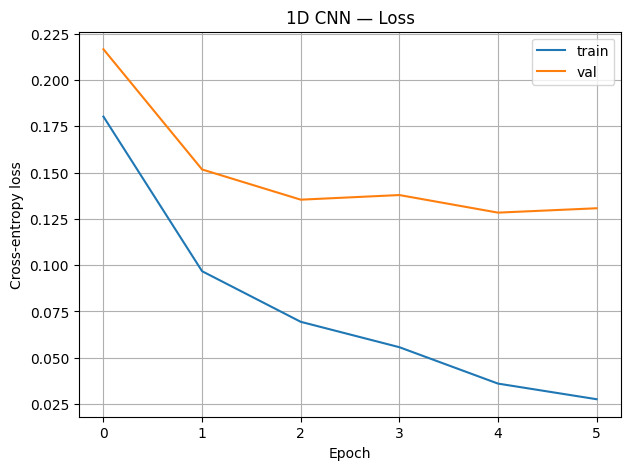

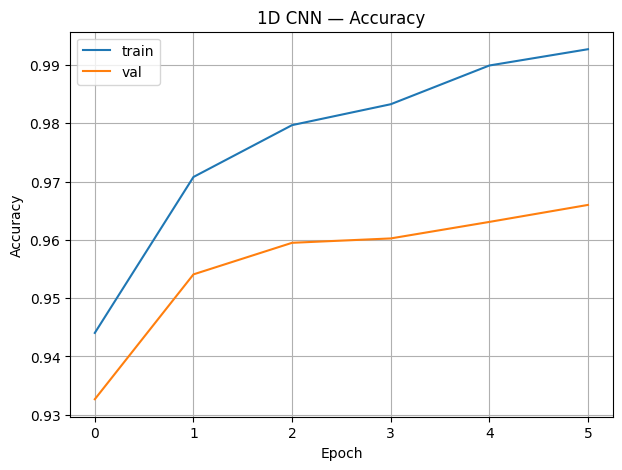

Validation accuracy: 0.9660
Test accuracy: 0.9673


In [16]:
model = Scratch1dCNNClassifier(
    conv_out=8, conv_kernel=7, conv_stride=2, conv_padding=0,
    hidden_dim=128,
    initializer='he', optimizer='adagrad', lr=0.2,
    batch_size=128, epochs=6, verbose=True
)
_ = model.fit(X_train, y_train_oh, X_val=X_val, y_val_onehot=y_val_oh, y_int=y_train, y_val_int=y_val)

# Learning curves
plt.figure(); plt.plot(model.train_loss_, label='train');
if len(model.val_loss_)==len(model.train_loss_): plt.plot(model.val_loss_, label='val')
plt.xlabel('Epoch'); plt.ylabel('Cross-entropy loss'); plt.title('1D CNN — Loss'); plt.legend(); plt.show()

if model.train_acc_ and model.val_acc_:
    plt.figure(); plt.plot(model.train_acc_, label='train'); plt.plot(model.val_acc_, label='val')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('1D CNN — Accuracy'); plt.legend(); plt.show()

# Final metrics
val_acc = accuracy_from_proba(y_val, model.predict_proba(X_val))
test_acc = accuracy_from_proba(y_test, model.predict_proba(X_test))
print('Validation accuracy:', f'{val_acc:.4f}')
print('Test accuracy:', f'{test_acc:.4f}')

To test this code reduce the number of epochs because it consumes a lot of time.

The accuracy increases with epochs, and losses reduce with each epoch.